# 데이터 전처리 

In [ ]:
# 한글 폰트를 사용하기 위한 코드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
%magic

In [ ]:
# 첫번째는 뉴스 제목을 갖고 어떤 토픽에 해당하는지 분류하는 모델 
# (Why?)
# 더 잘 분류하기 위해 데이터 전처리시 ~~작업들 진행
# 1)한자 및 영문자 사전을 만들어 한글로 변경해 전처리
# 2)특수문자, 숫자 및 기호 제거

## 1. 데이터 로드

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

plt.rc('font', family='NanumBarunGothic') 

In [81]:
PATH = '/content/drive/MyDrive/semi-projet/data'
df = pd.read_csv(PATH + '/train_0411_01.csv', index_col=0)
df.head()

,title,topic_idx
0,이상택 매일신문사 신임 사장,2
1,日 후쿠시마 원전 폐로 작업에 외국인력 활용한다,4
2,"현대차, ‘부울경’ 수소버스 보급 확대",3
3,국조특위 오늘 서울구치소 방문…최순실은 불출석 의사,6
4,통일부 통일교육 선도대학 공모…4∼5곳 지정 예정,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140773 entries, 0 to 140772
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      140773 non-null  object
 1   topic_idx  140773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


## 2. 데이터 탐색 (EDA)

In [ ]:
# 결측치 확인
df.isnull().sum()

title        0
topic_idx    0
dtype: int64

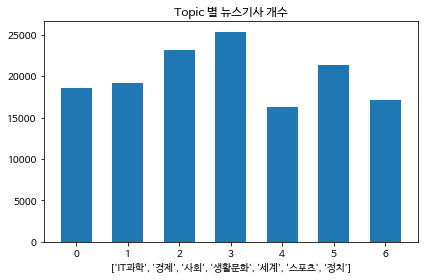

In [ ]:
# topic별 뉴스기사 수
plt.bar(df['topic_idx'].value_counts().index,
        df['topic_idx'].value_counts(),
        width=0.6)
plt.title('Topic 별 뉴스기사 개수')
plt.xlabel(['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'])
plt.tight_layout()
plt.show()

In [107]:
# IT과학 : 0
# 경제 : 1
# 사회 : 2
# 생활문화 : 3
# 세계 : 4
# 스포츠 : 5
# 정치 : 6
counts = df['topic_idx'].value_counts()
print(counts)
print()
print('총 데이터의 개수:', len(df))
print('가장 많은 topic:', f'{counts.index[0]}, 생활문화 {counts.max()}개')
print('가장 적은 topic:', f'{counts.index[-1]}, 세계 {counts.min()}개')
print('topic의 평균 개수:', counts.mean())
print()
print('가장 긴 title 길이:', df['title'].apply(len).max())
print('가장 짧은 title 길이:', df['title'].apply(len).min())
print('title의 길이평균:', df['title'].apply(len).mean())


3    21425
5    20914
2    20290
1    17452
0    15778
6    15175
4    14373
Name: topic_idx, dtype: int64

총 데이터의 개수: 125407
가장 많은 topic: 3, 생활문화 21425개
가장 적은 topic: 4, 세계 14373개
topic의 평균 개수: 17915.285714285714

가장 긴 title 길이: 95
가장 짧은 title 길이: 3
title의 길이평균: 30.432615404243784


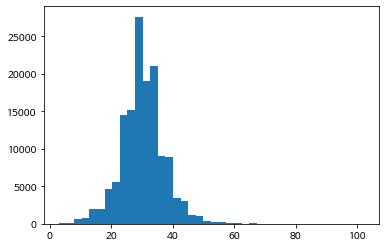

In [ ]:
# 뉴스 제목의 길이
plt.hist(df['title'].apply(len), bins=40)
plt.show()

In [ ]:
# 가장 긴 title 한번 확인 
# => 불필요한 헤드라인 문구와 중복된 title 존재 ([데일리안 오늘뉴스 종합])
df[df['title'].apply(len) == 102]

,title,topic_idx
2143,[데일리안 오늘뉴스 종합] 단일화시 尹 47.4% 李 41.5%…오차범위 밖 5.9...,1
3180,[데일리안 오늘뉴스 종합] 화성서 F-5 전투기 추락…조종사 1명 사망·'2215억...,3
23621,"[데일리안 오늘뉴스 종합] “다음은 저인가요?ㅜㅜ”, 국민의힘 ""김건희 불법 녹취,...",1
35590,"[데일리안 오늘뉴스 종합] 이준석 ""용산이 '오욕의 역사'면 청와대 부지는 조선총독...",6
45001,"[데일리안 오늘뉴스 종합] “다음은 저인가요?ㅜㅜ”, 국민의힘 ""김건희 불법 녹취,...",6
53593,"[데일리안 오늘뉴스 종합] 이준석 ""용산이 '오욕의 역사'면 청와대 부지는 조선총독...",2
55770,"[데일리안 오늘뉴스 종합] 문대통령 ""오미크론 정점 머지 않아…정부 믿어 달라"", ...",3
56251,[데일리안 오늘뉴스 종합] 8일밤 2차 '4자 TV토론'…기자협회 제안에 민주·국힘...,1
64070,"[데일리안 오늘뉴스 종합] 문대통령 ""오미크론 정점 머지 않아…정부 믿어 달라"", ...",0
65778,"[데일리안 오늘뉴스 종합] ""적은 내부에""…실언과 과한 해명에 역풍 맞는 이재명, ...",6


In [ ]:
# 가장 짧은 title 확인
df[df['title'].apply(len) == 3]

,title,topic_idx
43969,달려!,4
75034,달려!,4
121333,끝까지,4


## 3. 데이터 전처리
 - 한자 처리 : 국가(美 ->미국, 일, 한, 중, 북), 정치인(윤, 이, 문, 안)
 - 영문자, 특수문자, 기호는 제거
 - 중복되는 타이틀 제거

In [ ]:
# 한자를 처리하기 위한 라이브러리
# https://pypi.org/project/hanja/
!pip install hanja

In [ ]:
import hanja
from hanja import hangul
from collections import Counter

In [83]:
# 한자 찾기
title_list = list(df['title'])

hj = []
for title in title_list:
    if re.findall('[一-龥]', title):
        hj.append(re.findall('[一-龥]', title))
        
result = []
for i in hj:
    for char in i:
        result.append(char)

hanja_list = Counter(result).most_common()
print(hanja_list)
print(len(hanja_list))              # 총 318개
trans_list = hanja_list[:32]        # 318개 중 사용빈도 상위 10%

# 사용빈도 상위 10% 한자어 + 자주쓰는 한자어 목록
chi_kor_dic = {"美": "미국", "北":"북한", "中": "중국", '尹':"윤", '日':"일본", '文':'문', '靑':'청와대',
               '朴':'박', '韓':'한국', '與':'여당', '英':'영국', '野':'야당', '行':'행', '安':'안','軍':'군',
               '前':'전', '獨':'독일', '車':'차', '男':'남자', '伊':'이탈리아','檢':'검찰', '銀':'은행',
               '佛':'프랑스','南':'남한','亞':'아시아','展':'전시회','株':'주식'}


[('美', 3050), ('北', 2271), ('中', 1687), ('尹', 1117), ('日', 1087), ('文', 932), ('靑', 778), ('朴', 679), ('韓', 521), ('與', 477), ('英', 474), ('野', 286), ('軍', 223), ('前', 209), ('安', 206), ('獨', 190), ('車', 173), ('比', 153), ('外', 146), ('伊', 140), ('男', 135), ('佛', 133), ('故', 100), ('檢', 92), ('銀', 79), ('企', 77), ('反', 75), ('行', 73), ('亞', 71), ('人', 69), ('新', 59), ('無', 58), ('南', 53), ('重', 48), ('李', 47), ('對', 44), ('株', 42), ('硏', 40), ('女', 37), ('百', 35), ('金', 35), ('展', 32), ('發', 31), ('法', 30), ('兆', 28), ('親', 27), ('號', 27), ('戰', 25), ('印', 24), ('協', 23), ('詩', 22), ('大', 22), ('弗', 22), ('社', 17), ('色', 16), ('家', 16), ('黃', 16), ('洪', 16), ('史', 15), ('高', 15), ('非', 15), ('黨', 14), ('孫', 14), ('年', 14), ('道', 13), ('月', 13), ('證', 13), ('父', 12), ('先', 12), ('曺', 11), ('禹', 11), ('銅', 11), ('母', 11), ('風', 11), ('秋', 10), ('食', 9), ('沈', 9), ('脫', 9), ('委', 9), ('駐', 9), ('國', 8), ('巨', 8), ('生', 8), ('西', 8), ('潘', 8), ('心', 8), ('上', 8), ('産', 7), ('來', 7), ('代', 

In [84]:
# 한자 -> 한글로 변환
translated_title = []
for title in df['title']:
    for key, value in chi_kor_dic.items():
        title = title.replace(key, value)
        title
    title = hanja.translate(title, 'substitution')
    translated_title.append(title)

In [85]:
translated_title[:5]

['이상택 매일신문사 신임 사장',
 '일본 후쿠시마 원전 폐로 작업에 외국인력 활용한다',
 '현대차, ‘부울경’ 수소버스 보급 확대',
 '국조특위 오늘 서울구치소 방문…최순실은 불출석 의사',
 '통일부 통일교육 선도대학 공모…4∼5곳 지정 예정']

In [86]:
df['title'] = translated_title

# 한글이 아닌 숫자, 영문자, 기호 등은 공백문자로 치환 (특수문자들은 topic에 관련되어 있지 않음)
df['title'] = df['title'].apply(lambda x: re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\s]",  ' ', x))
df['title'] = df['title'].apply(lambda x: re.sub("데일리안 오늘뉴스 종합", ' ', x))

df['title']

0                         이상택 매일신문사 신임 사장
1             일본 후쿠시마 원전 폐로 작업에 외국인력 활용한다
2                   현대차   부울경  수소버스 보급 확대
3            국조특위 오늘 서울구치소 방문 최순실은 불출석 의사
4             통일부 통일교육 선도대학 공모    곳 지정 예정
                       ...               
140768    이재명   누구나집 으로 내집 마련 꿈 실현해 드릴 것 
140769          청와대 반기문 대선 출마 시사 발언에 말 아껴
140770        사이영상 투표한 미국 기자 류현진 수상 자격 있어
140771     이스라엘  코로나   확진자 격리기간   일  일 단축
140772      독도로 출발하기 전 기념촬영 하는 독도아카데미 대학생
Name: title, Length: 126043, dtype: object

In [87]:
# 중복 제거
df.drop_duplicates(['title'], keep='first', inplace=True)
print(len(df))
print(df['topic_idx'].value_counts())

125407
3    21425
5    20914
2    20290
1    17452
0    15778
6    15175
4    14373
Name: topic_idx, dtype: int64


In [ ]:
# 토픽별로 균등한 데이터 개수를 맞춰주기 위해 DownSampling
# 각 토픽별 16227개씩 총 113589개
sampling_size = df['topic_idx'].value_counts().min()
sampling_idx = list(df['topic_idx'].value_counts().index())

rand_sample = df[df['topic_idx'] == sampling_idx[0]].sample(sampling_size)
rand_sample.head()

In [ ]:
for idx in sampling_idx[1:]:
    sampling = df[df['topic_idx'] == idx].sample(sampling_size)
    rand_sample = pd.concat([rand_sample, sampling])
print(len(rand_sample))

In [ ]:
rand_sample['topic_idx'].value_counts()

In [88]:
# 전처리 완료된 csv파일 저장
rand_sample.to_csv(PATH + '/train_0411_02.csv')